## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
%matplotlib inline

В этом примере мы попробуем предсказать итоговую оценку участинка только на основе **его действий**

In [2]:
df_train = pd.read_csv("train.csv")
df_user = pd.read_csv("user_decision.csv")

## Рассмотрим датасет по ближе

In [3]:
df_train.shape


(680, 5)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   680 non-null    int64  
 1   Analytical thinking  680 non-null    float64
 2   Systemic thinking    680 non-null    float64
 3   Adaptability         680 non-null    float64
 4   Focus                680 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 26.7 KB


In [5]:
df_train.head(30)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0
5,10908,4.0,4.0,5.0,5.0
6,10378,4.0,5.0,5.0,4.0
7,10220,5.0,4.0,5.0,5.0
8,10612,5.0,4.0,4.0,5.0
9,10776,4.0,4.0,5.0,5.0


In [6]:
df_user.shape

(60228, 3)

In [7]:
df_user.head(3)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420


In [8]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60228 entries, 0 to 60227
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      60228 non-null  int64
 1   period       60228 non-null  int64
 2   decision_id  60228 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


Заметим что в есть категория где пользватель совершал больше действий

In [9]:
df_user.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение периода')

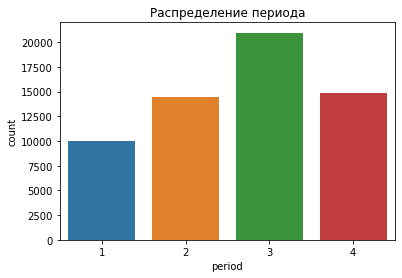

In [10]:
sns.countplot(x = "period" , data  = df_user).set_title('Распределение периода')

Text(0.5, 1.0, 'Распределение действий')

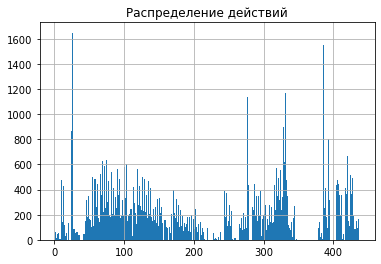

In [11]:
df_user["decision_id"].hist(bins = 300).set_title('Распределение действий')

### Добавим новых значений

Узнаем частоту команд участника в каждом периоде

In [12]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in df_train.id.values)]

In [13]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [14]:
df_decision_count.head(5)

decision_id
user_id period             
10001   1                29
        2                23
        3                39
        4                15
10003   1                21

In [15]:
for id in df_train.id.values:
  for period in range(1,5):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [16]:
df_train.head(3)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0


In [17]:

df_train['Adaptability'].value_counts()

5.0    318
4.0    308
3.0     36
6.0     15
1.0      2
2.0      1
Name: Adaptability, dtype: int64


focus1=df_train.query("Adaptability==2").head()
focus2=df_train.query("Adaptability==1").head()
focus3=df_train.query("Adaptability==6").head()
focus4=df_train.query("Adaptability==3").head()
for i in range(1,10):
    df_train=df_train.append(focus1, ignore_index=True)
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)
    df_train=df_train.append(focus4, ignore_index=True)

In [18]:
df_train['Adaptability'].value_counts()

5.0    318
4.0    308
3.0     36
6.0     15
1.0      2
2.0      1
Name: Adaptability, dtype: int64

In [19]:
df_train = df_train.dropna()

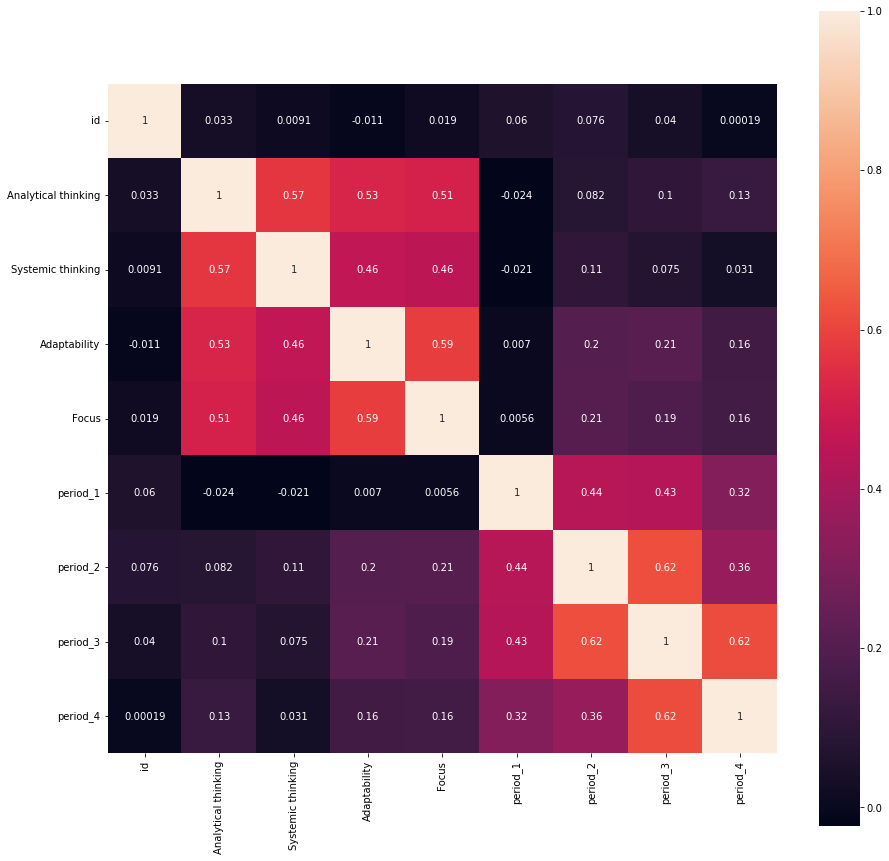

In [20]:
plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(df_train.corr(), square = True, annot=True)

In [21]:
df_train

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0
3,10130,5.0,4.0,5.0,5.0,26.0,28.0,34.0,66.0
4,10667,4.0,5.0,5.0,5.0,58.0,70.0,194.0,35.0
...,...,...,...,...,...,...,...,...,...
674,10303,5.0,5.0,5.0,5.0,1.0,22.0,19.0,13.0
675,10563,5.0,4.0,5.0,4.0,10.0,2.0,14.0,4.0
676,10386,5.0,4.0,5.0,5.0,1.0,14.0,24.0,1.0
677,10675,5.0,4.0,5.0,4.0,4.0,17.0,23.0,12.0


In [22]:
df_train['Focus'].value_counts()

4.0    230
5.0    188
3.0     16
6.0      3
1.0      2
Name: Focus, dtype: int64

In [23]:
df_train['Adaptability'].value_counts()

5.0    229
4.0    179
3.0     18
6.0     12
1.0      1
Name: Adaptability, dtype: int64

In [24]:
focus2=df_train.query("Adaptability==1").head(25)
for i in range(1,10):
    df_train=df_train.append(focus2, ignore_index=True)
    

/tmp/ipykernel_4487/2939596762.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(focus2, ignore_index=True)


In [25]:
focus2=df_train.query("Focus==1").head(25)
focus3=df_train.query("Focus==6").head(25)
for i in range(1,5):
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)

/tmp/ipykernel_4487/2346153193.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(focus2, ignore_index=True)
/tmp/ipykernel_4487/2346153193.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append(focus3, ignore_index=True)


## Выделим выборки

In [26]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Analytical thinking']


In [27]:
X.shape

(504, 4)

In [28]:
X

,period_1,period_2,period_3,period_4
0,7.0,14.0,28.0,10.0
1,21.0,21.0,12.0,8.0
2,62.0,45.0,63.0,38.0
3,26.0,28.0,34.0,66.0
4,58.0,70.0,194.0,35.0
...,...,...,...,...
499,45.0,26.0,44.0,37.0
500,45.0,26.0,44.0,37.0
501,4.0,42.0,6.0,9.0
502,4.0,42.0,15.0,19.0


In [29]:
y

0      4.0
1      5.0
2      6.0
3      5.0
4      4.0
      ... 
499    1.0
500    1.0
501    6.0
502    5.0
503    5.0
Name: Analytical thinking, Length: 504, dtype: float64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение модели

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
rf_model_Analytical_thinking =  RandomForestClassifier(criterion='entropy',max_depth=7,min_samples_leaf=1,min_samples_split=3,n_estimators=5) # Ваш код здесь
# обучим модель случайного леса
rf_model_Analytical_thinking.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, min_samples_split=3,
                       n_estimators=5)

rf_model =  RandomForestClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10, 51, 2),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,1) }

grid = GridSearchCV(rf_model, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

## Оценка точности

In [32]:
pred = rf_model_Analytical_thinking.predict(X_test)

In [33]:
pred

array([4., 4., 5., 4., 4., 4., 5., 5., 1., 1., 5., 4., 1., 4., 5., 5., 4.,
       5., 4., 1., 5., 4., 4., 1., 5., 1., 4., 4., 5., 1., 4., 1., 4., 4.,
       1., 5., 4., 4., 4., 5., 1., 1., 4., 4., 4., 4., 4., 4., 1., 4., 4.,
       4., 4., 4., 4., 1., 1., 4., 4., 4., 4., 4., 4., 5., 4., 4., 5., 5.,
       5., 1., 4., 5., 4., 5., 4., 5., 4., 4., 4., 6., 4., 5., 4., 4., 5.,
       4., 1., 4., 4., 5., 4., 4., 4., 6., 4., 5., 4., 4., 5., 5., 5.])

In [34]:

print (classification_report(y_test, pred))

/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        16
         3.0       0.00      0.00      0.00         5
         4.0       0.53      0.68      0.59        44
         5.0       0.42      0.34      0.38        32
         6.0       1.00      0.50      0.67         4

    accuracy                           0.58       101
   macro avg       0.59      0.51      0.53       101
weighted avg       0.56      0.58      0.56       101



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
X = df_train.drop(['Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Systemic thinking']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_Systemic_thinking =  RandomForestClassifier(criterion='entropy' ,max_depth=7,min_samples_leaf=6,min_samples_split=7,n_estimators=37) # Ваш код здесь
# обучим модель случайного леса
rf_model_Systemic_thinking.fit(X_train, y_train)
pred = rf_model_Systemic_thinking.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        16
         3.0       0.00      0.00      0.00         4
         4.0       0.73      0.98      0.84        60
         5.0       1.00      0.17      0.29        18
         6.0       0.00      0.00      0.00         3

    accuracy                           0.77       101
   macro avg       0.55      0.43      0.42       101
weighted avg       0.77      0.77      0.71       101



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf_model =  RandomForestClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10, 51, 2),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,1) }

grid = GridSearchCV(rf_model, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

In [36]:
X = df_train.drop(['Adaptability', 'Focus','id'], axis = 1)
y = df_train['Adaptability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_Adaptability =  RandomForestClassifier(criterion='entropy',max_depth=7,min_samples_leaf=4,min_samples_split=5,n_estimators=13) # Ваш код здесь
# обучим модель случайного леса
rf_model_Adaptability.fit(X_train, y_train)
pred = rf_model_Adaptability.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        16
         3.0       0.00      0.00      0.00         4
         4.0       0.53      0.51      0.52        35
         5.0       0.59      0.71      0.65        42
         6.0       0.00      0.00      0.00         4

    accuracy                           0.63       101
   macro avg       0.42      0.45      0.43       101
weighted avg       0.59      0.63      0.61       101



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf_model =  RandomForestClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10, 51, 2),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,1) }

grid = GridSearchCV(rf_model, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

In [37]:
X = df_train.drop(['Focus','id'], axis = 1)
y = df_train['Focus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_Focus =  RandomForestClassifier(criterion='entropy',max_depth=7,min_samples_leaf=1,min_samples_split=2,n_estimators=10) # Ваш код здесь
# обучим модель случайного леса
rf_model_Focus.fit(X_train, y_train)
pred = rf_model_Focus.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        16
         3.0       0.00      0.00      0.00         1
         4.0       0.71      0.74      0.73        47
         5.0       0.64      0.58      0.61        31
         6.0       1.00      1.00      1.00         6

    accuracy                           0.74       101
   macro avg       0.67      0.67      0.67       101
weighted avg       0.75      0.74      0.74       101



rf_model =  RandomForestClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10, 51, 2),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,1) }

grid = GridSearchCV(rf_model, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

In [38]:
# Предикт.

In [39]:
datapre=pd.read_csv('sample_solution.csv')

In [40]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [41]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in datapre.id.values)]

In [42]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [43]:
df_decision_count.head(5)

decision_id
user_id period             
10002   2                 9
        3                25
        4                22
10005   1                14
        2                34

In [44]:
for id in datapre.id.values:
  for period in range(1,5):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [45]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10199,0,0,0,0,2.0,2.0,3.0,2.0
1,10539,0,0,0,0,1.0,9.0,15.0,17.0
2,10174,0,0,0,0,NaN,28.0,31.0,20.0
3,10465,0,0,0,0,15.0,18.0,32.0,18.0
4,10066,0,0,0,0,8.0,23.0,16.0,6.0
...,...,...,...,...,...,...,...,...,...
288,10433,0,0,0,0,18.0,7.0,1.0,NaN
289,10893,0,0,0,0,21.0,52.0,34.0,20.0
290,10909,0,0,0,0,NaN,NaN,NaN,1.0
291,10889,0,0,0,0,6.0,2.0,5.0,1.0


In [46]:
datapre.fillna(0, inplace=True)
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10199,0,0,0,0,2.0,2.0,3.0,2.0
1,10539,0,0,0,0,1.0,9.0,15.0,17.0
2,10174,0,0,0,0,0.0,28.0,31.0,20.0
3,10465,0,0,0,0,15.0,18.0,32.0,18.0
4,10066,0,0,0,0,8.0,23.0,16.0,6.0
...,...,...,...,...,...,...,...,...,...
288,10433,0,0,0,0,18.0,7.0,1.0,0.0
289,10893,0,0,0,0,21.0,52.0,34.0,20.0
290,10909,0,0,0,0,0.0,0.0,0.0,1.0
291,10889,0,0,0,0,6.0,2.0,5.0,1.0


In [47]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Analytical_thinking = rf_model_Analytical_thinking.predict(X)
pred_Analytical_thinking

array([4., 5., 5., 4., 4., 5., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5.,
       1., 5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 5., 4.,
       4., 4., 6., 5., 5., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 5.,
       4., 5., 4., 4., 5., 5., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 5., 6., 5., 4., 4., 4., 4., 3., 4., 5., 4., 4., 4., 5., 5., 6.,
       4., 5., 4., 4., 5., 5., 4., 4., 5., 5., 5., 5., 5., 5., 4., 4., 4.,
       4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5.,
       4., 5., 5., 5., 4., 4., 4., 4., 6., 4., 4., 4., 4., 5., 4., 5., 5.,
       4., 5., 4., 6., 4., 4., 4., 4., 5., 6., 5., 5., 5., 4., 4., 4., 4.,
       4., 4., 5., 4., 5., 4., 4., 6., 4., 4., 4., 4., 4., 5., 5., 4., 4.,
       4., 4., 4., 5., 6., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4.,
       6., 4., 4., 4., 4., 4., 5., 5., 5., 5., 4., 4., 5., 4., 4., 4., 6.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4.,
       5., 6., 6., 4., 4.

In [48]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
X['Analytical_thinking']=pred_Analytical_thinking
pred_Systemic_thinking = rf_model_Systemic_thinking.predict(X)
pred_Systemic_thinking

/home/gennalll/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Analytical_thinking
Feature names seen at fit time, yet now missing:
- Analytical thinking

  warnings.warn(message, FutureWarning)


array([1., 1., 1., 4., 4., 1., 1., 4., 1., 4., 1., 4., 1., 4., 5., 4., 1.,
       1., 4., 4., 4., 4., 4., 1., 5., 4., 4., 5., 1., 1., 4., 4., 1., 4.,
       4., 4., 1., 1., 4., 4., 5., 1., 4., 4., 5., 1., 4., 4., 1., 4., 1.,
       4., 1., 4., 4., 4., 1., 1., 1., 4., 4., 4., 5., 4., 1., 4., 5., 4.,
       4., 5., 1., 1., 4., 1., 4., 4., 1., 5., 1., 4., 4., 4., 4., 1., 1.,
       4., 1., 5., 4., 1., 1., 1., 4., 1., 1., 4., 4., 4., 4., 4., 5., 1.,
       4., 1., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 1., 1., 5.,
       4., 4., 4., 1., 4., 4., 4., 1., 1., 4., 5., 4., 5., 4., 4., 1., 1.,
       1., 1., 4., 1., 4., 1., 4., 4., 1., 1., 5., 5., 4., 4., 4., 1., 5.,
       4., 1., 4., 1., 1., 4., 4., 1., 4., 1., 5., 1., 4., 1., 1., 4., 4.,
       4., 1., 4., 1., 1., 4., 1., 4., 4., 5., 4., 1., 4., 4., 4., 4., 4.,
       1., 4., 4., 1., 5., 4., 1., 1., 1., 1., 4., 1., 1., 5., 4., 4., 1.,
       4., 4., 4., 4., 4., 5., 4., 4., 1., 1., 1., 4., 5., 4., 1., 1., 4.,
       1., 1., 1., 4., 4.

In [49]:
X = datapre.drop(['Adaptability', 'Focus','id'], axis = 1)
X['Systemic thinking']=pred_Systemic_thinking
pred_Adaptability = rf_model_Adaptability.predict(X)
pred_Adaptability

array([3., 1., 1., 5., 4., 3., 1., 4., 3., 4., 3., 4., 1., 4., 3., 4., 1.,
       3., 1., 1., 1., 4., 4., 3., 5., 4., 4., 4., 3., 3., 4., 4., 3., 4.,
       4., 4., 3., 1., 1., 1., 4., 3., 4., 1., 4., 1., 4., 4., 1., 4., 1.,
       4., 3., 4., 4., 5., 3., 3., 3., 4., 5., 4., 4., 4., 3., 4., 5., 1.,
       4., 4., 3., 3., 4., 3., 4., 4., 3., 4., 1., 4., 4., 4., 4., 3., 3.,
       4., 1., 5., 4., 3., 1., 3., 4., 3., 1., 5., 4., 4., 1., 1., 4., 3.,
       4., 3., 4., 4., 4., 1., 4., 4., 4., 4., 4., 1., 4., 4., 1., 1., 4.,
       4., 1., 1., 1., 4., 4., 1., 1., 3., 4., 5., 4., 5., 1., 4., 3., 3.,
       3., 3., 4., 3., 4., 3., 4., 4., 3., 3., 4., 4., 4., 4., 4., 3., 4.,
       5., 3., 4., 1., 3., 4., 4., 3., 4., 3., 4., 3., 4., 3., 1., 4., 5.,
       4., 1., 4., 3., 3., 4., 1., 4., 4., 4., 4., 1., 4., 4., 1., 4., 4.,
       3., 4., 4., 3., 5., 4., 3., 3., 3., 3., 4., 3., 3., 5., 1., 4., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 1., 3., 1., 1., 5., 5., 1., 1., 1.,
       1., 3., 3., 4., 4.

In [50]:
X = datapre.drop(['Focus','id'], axis = 1)
X['Adaptability']=pred_Adaptability
pred_Focus = rf_model_Focus.predict(X)
len(pred_Focus)

293

In [51]:
datapre=pd.read_csv('sample_solution.csv')
datapre  

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [52]:
datapre['Analytical thinking']=pred_Analytical_thinking
datapre['Systemic thinking']=pred_Systemic_thinking
datapre['Adaptability']=pred_Adaptability
datapre['Focus']=pred_Focus

In [53]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB


In [54]:
datapre.to_csv('datapredep1.csv',index=False)

In [55]:
dataprev=pd.read_csv('datapredep1.csv')

In [56]:
dataprev['Adaptability'].value_counts()

4.0    133
3.0     77
1.0     59
5.0     24
Name: Adaptability, dtype: int64